# Demo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
from tqdm import tqdm
import imageio
import cv2
from itertools import product
import shutil
# import multiprocess as mp

sys.path.append("./utils")
from myUtils import mkdir
from caUtils import plot_simulation, load_data
from Model import Model

# Format plots
sns.set(style="white",
        font="Serif",
        rc={'figure.figsize':(12,6)})

In [8]:
### Script parameters
runCASimulations = True # Whether to run the CA simulations to generate the data analysed in this script
jarFileName = "./HAL_fds.jar"
# nProcesses = 4 # Number of cores to use for multi-processing
# palette_sensitiveResistant = {"S":"#0F4C13", "R":"#710303"} # Red/green scheme
palette_sensitiveResistant = {"S":"#5E7FDD", "R":"#D0D645", "TumourSize":"black"}
modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':500,"saveModelState":True,"dieProb":0.01,
                  "localFreq":1}
dataDir = "./data/cellCountLog"
imgDir = "./data/demo/images"
seedToShowImagesFor = 1
# treatmentScheduleList = [[0,10,0], [10,50,1]]

### Script parameters
runCASimulations = True # Whether to run the CA simulations to generate the data analysed in this script
# jarFileName = "./code.jar"
# nProcesses = 4 # Number of cores to use for multi-processing
palette_sensitiveResistant = {"S":"#5E7FDD", "R":"#D0D645", "TumourSize":"black"}

myModel = Model(jarFileName = jarFileName, outDir=dataDir, **modelConfigDic)
myModel.Simulate()

In [26]:
# Collect the images for one replicate
myModel = OnLatticeModel(jarFileName = jarFileName, **modelConfigDic)
myModel.SetParams(seed=seedToShowImagesFor, nReplicates=1, 
                  imageOutDir=imgDir, imageFrequency=1, outDir="./data/scratch/") # Adjust config for imaging
myModel.Simulate(treatmentScheduleList=treatmentScheduleList)

### Plot the simulations

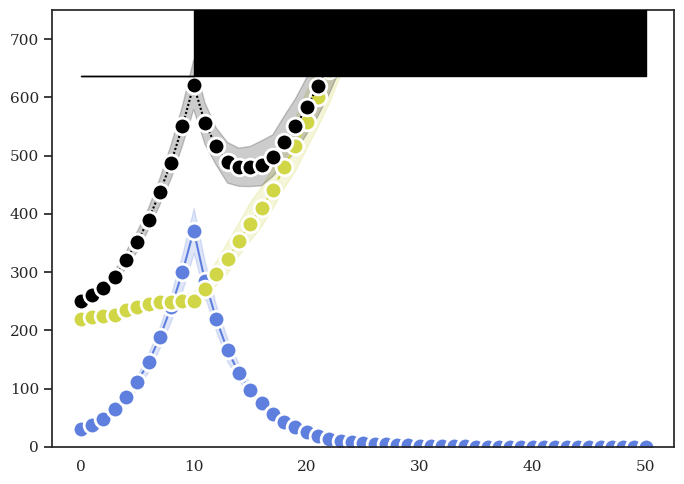

In [27]:
dataDf = load_data(dataDir=dataDir, nReplicates=modelConfigDic['nReplicates'], measurementFrequency=10)
# plot_simulation(dataDf,plotIndividualTrajectories=False)
plot_simulation(dataDf=dataDf, feature='Confluence', treatmentScheduleList=treatmentScheduleList,
         hue="CellType", style="CellType", palette=palette_sensitiveResistant, ylim=750, figsize=(7,5))

### Plot Images

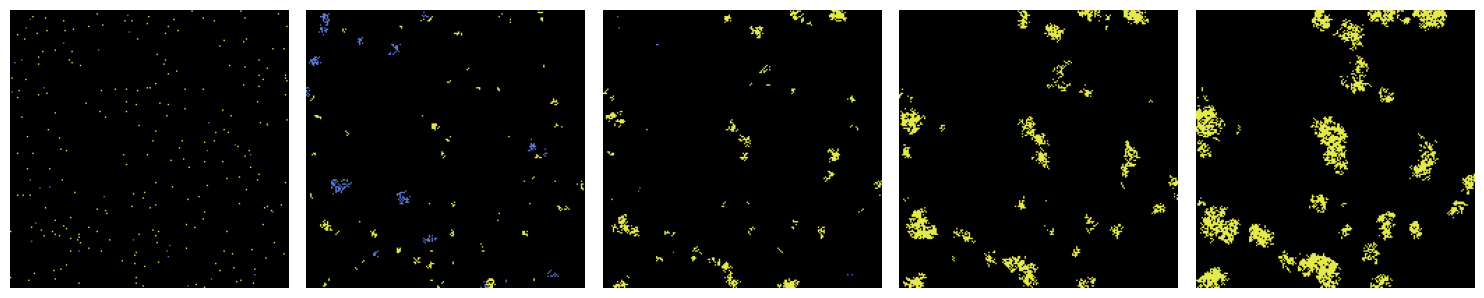

In [30]:
timePointList = np.linspace(0, treatmentScheduleList[-1][1], 5)

fig,axList = plt.subplots(1, len(timePointList), figsize=(15, len(timePointList)*5))
for i,timePoint in enumerate(timePointList):
    # Load image
    currImgDir = os.path.join(imgDir,"RepId_%d"%(seedToShowImagesFor))
    currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(int(timePoint))))
    currImg = cv2.cvtColor(currImg, cv2.COLOR_BGR2RGB)

    currAx = axList[i]
    currAx.imshow(currImg)
    currAx.axis('off')
plt.tight_layout()
# plt.savefig("figures/exampleSim_noCost_noTurnover_images.pdf")

### Make gif

In [36]:
timePointList = np.arange(0, treatmentScheduleList[-1][1], 2)
# Make an inventory of the images that are available
currImgDir = os.path.join(imgDir,"RepId_%d"%(seedToShowImagesFor))
fNameList = [int(float(x.split("_")[-1].split(".png")[0])) for x in os.listdir(currImgDir) if x.split(".")[-1]=="png"]
fNameList.sort()
images = []

for timePoint in fNameList[::]:
    fig,currAx = plt.subplots(1,1,figsize=(12,12))
    # Load image
    currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(int(timePoint))))
    currImg = cv2.cvtColor(currImg, cv2.COLOR_BGR2RGB)
    currImg = cv2.putText(currImg, 't = %dd'%timePoint, (10,390), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    # Add a square to indicate that drug is on
    currDfName = os.path.join(dataDir,"RepId_%d.csv"%seedToShowImagesFor)
    tmpDf = pd.read_csv(currDfName)
    if tmpDf[tmpDf.Time==timePoint].DrugConcentration.iloc[0]>0:
        cv2.rectangle(currImg, (375, 25), (397, 3), (255,255,255), -1)
    images.append(currImg)
    plt.close()
imageio.mimsave("test.gif", images, duration=.25)
# # plt.savefig("figures/exampleSim_noCost_noTurnover_images.pdf")

<img src="test.gif" width="500" align="center">

**Note:** the gif is loaded from filed into the notebook. Sometimes it will cache it and not update it until you reload the nb. So if you change params and see no difference in the simulation, try reloading the page, or just look straight at the gif in your folder (safer option).